# Jupiter's Notebook for Scenario 03
Requieres: [CategoryEncoders](http://contrib.scikit-learn.org/category_encoders/), [imbalanced-learn](https://imbalanced-learn.org/stable/), [XGBoost](https://pypi.org/project/xgboost/), and [dill](https://pypi.org/project/dill/)<br>
`pip install category_encoders`<br>
`pip install imbalanced-learn`<br>
`pip install xgboost`<br>
`pip install dill`

In [1]:
#import libraries
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
#To identify class 0 and 1, respectively
target_names = ['class 0', 'class 1']

In [3]:
#load dataset
df=pd.read_csv('esc-03-Mixed-traffic.csv')

In [4]:
#No trunkated 
pd.set_option('display.max_columns', None)

In [5]:
#Dataset dimensions, number of sessions and features
df.shape

(425649, 52)

In [6]:
#counting classes
collections.Counter(df.label.values)

Counter({0: 422898, 1: 2751})

In [7]:
#check the number of null values
print(df.isnull().sum())
print(df.isnull().values.sum())

proto                 0
ts                    0
srcIP                 0
srcPrt                0
dstIP                 0
dstPrt                0
flowduration          0
total_fpackets        0
total_bpackets        0
total_fpktl           0
total_bpktl           0
min_fpktl             0
min_bpktl             0
max_fpktl             0
max_bpktl             0
mean_fpktl            0
mean_bpktl            0
std_fpktl             0
std_bpktl             0
total_fipt            0
total_bipt            0
min_fipt              0
min_bipt              0
max_fipt              0
max_bipt              0
mean_fipt             0
mean_bipt             0
std_fipt              0
std_bipt              0
fpsh_cnt              0
bpsh_cnt              0
furg_cnt              0
burg_cnt              0
total_fhlen           0
total_bhlen           0
fPktsPerSecond        0
bPktsPerSecond        0
flowPktsPerSecond     0
flowBytesPerSecond    0
mean_flowpktl         0
std_flowpktl          0
mean_flowipt    

In [8]:
#Dropping Rows with NA inplace
df.dropna(inplace=True)

In [9]:
#sumarize the number of unique values for each column 
print(df.nunique())

proto                      2
ts                    425649
srcIP                  14548
srcPrt                 58384
dstIP                  14533
dstPrt                   210
flowduration          243270
total_fpackets           734
total_bpackets           909
total_fpktl             8911
total_bpktl            19117
min_fpktl                133
min_bpktl                495
max_fpktl               1207
max_bpktl                901
mean_fpktl             17918
mean_bpktl             22846
std_fpktl              31081
std_bpktl              29105
total_fipt             99977
total_bipt             80181
min_fipt               57495
min_bipt               32892
max_fipt               97386
max_bipt               74151
mean_fipt              96833
mean_bipt              78646
std_fipt               75211
std_bipt               65535
fpsh_cnt                 137
bpsh_cnt                 413
furg_cnt                   1
burg_cnt                   1
total_fhlen             3302
total_bhlen   

In [10]:
# Delete time stamp (ts), srcIP and dstIP features
# Models do not learn with IP addresses
df.drop(['ts','srcIP','dstIP'],axis=1,inplace=True)

In [11]:
#Dataset dimensions, number of sessions and features
print(df.shape)

(425649, 49)


In [12]:
#Delete Rows That Contain Duplicate Data
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(425649, 49)
(422778, 49)


In [13]:
df

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio,label
0,TCP,37243,25,1.018562,3,3,186,162,62,54,62,54,62.000000,54.000000,0.000000,0.000000,1.018543,1.018556,0.439612,0.439620,0.578931,0.578936,0.509272,0.509278,0.098514,0.098511,0,0,0,0,84,60,2.945328,2.945328,5.890657,3.416581e+02,58.000000,4.381781,0.203716,0.283249,0,3,3,3,0,0,0,0.870968,0
1,TCP,63152,80,0.477808,11,16,1106,15237,60,54,500,1434,100.545456,952.312500,132.496308,647.964582,0.477808,0.384525,0.000013,0.000008,0.096229,0.098419,0.047781,0.025635,0.048928,0.043713,1,4,0,0,232,332,23.021799,33.486256,56.508053,3.420412e+04,605.296296,656.407898,0.018434,0.037705,2,2,0,26,0,0,0,13.776672,0
2,TCP,52841,80,0.309601,6,7,629,6065,60,54,327,1434,104.833336,866.428589,108.841931,709.772701,0.309601,0.218167,0.001297,0.000007,0.110473,0.107681,0.061920,0.036361,0.049018,0.049490,1,2,0,0,128,148,19.379793,22.609758,41.989552,2.162139e+04,514.923077,642.639771,0.027473,0.042772,0,2,1,12,0,0,0,9.642289,0
3,TCP,80,26739,60.019398,2,0,2868,0,1434,0,1434,0,1434.000000,0.000000,0.000000,0.000000,60.019398,0.000000,60.019398,0.000000,60.019398,0.000000,60.019398,0.000000,0.000000,0.000000,2,0,0,0,40,0,0.033323,0.000000,0.033323,4.778455e+01,1434.000000,0.000000,60.019398,0.000000,0,0,0,2,0,0,0,0.000000,0
4,TCP,38554,80,17.941672,48,87,4594,116619,60,54,914,1434,95.708336,1340.448242,172.433400,311.199625,17.941672,15.261713,0.000030,0.000005,12.896225,12.801347,0.381738,0.177462,1.895964,1.380463,2,3,0,0,972,1752,2.675336,4.849046,7.524382,6.755948e+03,897.874074,655.934814,0.227301,1.555660,1,2,1,134,0,0,0,25.385067,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425644,UDP,47379,53,0.000000,1,0,71,0,71,0,71,0,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,37,0,0.000000,0.000000,0.000000,0.000000e+00,71.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0.000000,0
425645,UDP,65320,53,0.000345,1,1,83,175,83,175,83,175,83.000000,175.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,49,141,2898.620605,2898.620605,5797.241211,7.478441e+05,129.000000,65.053825,0.000345,0.000000,0,0,0,0,0,0,0,2.108434,0
425646,UDP,31073,53,0.000231,1,1,85,177,85,177,85,177,85.000000,177.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,51,143,4328.487305,4328.487305,8656.974609,1.134064e+06,131.000000,65.053825,0.000231,0.000000,0,0,0,0,0,0,0,2.082353,0
425647,UDP,6141,53,0.000173,1,1,85,144,85,144,85,144,85.000000,144.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,51,110,5777.278320,5777.278320,11554.556641,1.322997e+06,114.500000,41.719299,0.000173,0.000000,0,0,0,0,0,0,0,1.694118,0


In [14]:
#check % class distribution 
y=df['label'].values #convert to nparray

classes=np.unique(y)
total=len(y)

for c in classes:
    n_examples=len(y[y==c])
    percent = n_examples/total*100
    print('> Class %d : %d of %d (%.1f%%)' % (c, n_examples,total,percent))

> Class 0 : 420074 of 422778 (99.4%)
> Class 1 : 2704 of 422778 (0.6%)


# Create training and test dataset

In [15]:
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

In [16]:
#Original dataset dimensions
X_train.shape, X_test.shape

((338222, 48), (84556, 48))

# Coding of categorical variables
[Target encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) for categorical features will be used to encode three nominal categorical variables: protocol, source and destination ports. This method is supervised and requires training.

In [17]:
#load library for target encoder 
from category_encoders import TargetEncoder

In [18]:
#check data types for each feature
df.dtypes

proto                  object
srcPrt                  int64
dstPrt                  int64
flowduration          float64
total_fpackets          int64
total_bpackets          int64
total_fpktl             int64
total_bpktl             int64
min_fpktl               int64
min_bpktl               int64
max_fpktl               int64
max_bpktl               int64
mean_fpktl            float64
mean_bpktl            float64
std_fpktl             float64
std_bpktl             float64
total_fipt            float64
total_bipt            float64
min_fipt              float64
min_bipt              float64
max_fipt              float64
max_bipt              float64
mean_fipt             float64
mean_bipt             float64
std_fipt              float64
std_bipt              float64
fpsh_cnt                int64
bpsh_cnt                int64
furg_cnt                int64
burg_cnt                int64
total_fhlen             int64
total_bhlen             int64
fPktsPerSecond        float64
bPktsPerSe

In [19]:
# Selecting the three categorical variables to be coded
enc = TargetEncoder(cols=['proto','srcPrt','dstPrt'])
# fit on the trainning dataset
enc.fit_transform(X_train, y_train)
# Coding categorical variables of the trainning dataset
training_numeric_dataset=enc.transform(X_train)
# Coding categorical variables of the test dataset
testing_numeric_dataset = enc.transform(X_test)

In [20]:
#show trainning dataset
training_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
406917,0.00021,1.069572e-07,0.000023,2.351661,1,1,74,303,74,303,74,303,74.000000,303.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,40,269,0.425231,0.425231,0.850463,1.603122e+02,188.5,161.927460,2.351661,0.000000,0,0,0,0,0,0,0,4.094594
338618,0.00021,0.000000e+00,0.000023,0.649577,1,1,82,227,82,227,82,227,82.000000,227.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,48,193,1.539464,1.539464,3.078927,4.756942e+02,154.5,102.530487,0.649577,0.000000,0,0,0,0,0,0,0,2.768293
240805,0.00021,1.151851e-04,0.000023,0.002353,2,2,169,301,79,149,90,152,84.500000,150.5,7.778175,2.12132,0.002135,0.002185,0.002135,0.002185,0.002135,0.002185,0.002135,0.002185,0.000000,0.0,0,0,0,0,101,233,849.995728,849.995728,1699.991455,1.997490e+05,117.5,38.388367,0.000840,0.001122,0,0,0,0,0,0,0,1.781065
182074,0.00021,4.286154e-05,0.000023,0.000111,1,1,161,54,161,54,161,54,161.000000,54.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,127,20,9000.652344,9000.652344,18001.304688,1.935140e+06,107.5,75.660423,0.000111,0.000000,0,0,0,0,0,0,0,0.335404
314247,0.00021,3.037190e-04,0.000023,1.976254,2,2,176,934,88,467,88,467,88.000000,467.0,0.000000,0.00000,1.975742,1.117279,1.975742,1.117279,1.975742,1.117279,1.975742,1.117279,0.000000,0.0,0,0,0,0,108,866,1.012016,1.012016,2.024031,5.616687e+02,277.5,218.815750,0.945076,0.990426,0,0,0,0,0,0,0,5.306818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260878,0.00021,7.902285e-07,0.000023,0.000472,1,1,72,347,72,347,72,347,72.000000,347.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,38,313,2118.335449,2118.335449,4236.670898,8.875825e+05,209.5,194.454361,0.000472,0.000000,0,0,0,0,0,0,0,4.819445
368261,0.00021,7.633848e-04,0.000023,0.000242,1,1,81,149,81,149,81,149,81.000000,149.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,47,115,4132.319336,4132.319336,8264.638672,9.504334e+05,115.0,48.083260,0.000242,0.000000,0,0,0,0,0,0,0,1.839506
132675,0.00021,2.147608e-06,0.000023,0.000240,1,1,85,136,85,136,85,136,85.000000,136.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,51,102,4169.288086,4169.288086,8338.576172,9.214127e+05,110.5,36.062447,0.000240,0.000000,0,0,0,0,0,0,0,1.600000
147732,0.00021,0.000000e+00,0.000023,61.150707,10,0,808,0,71,0,86,0,80.800003,0.0,5.159673,0.00000,61.150707,0.000000,0.000007,0.000000,12.498611,0.000000,6.794523,0.000000,5.594151,0.0,0,0,0,0,468,0,0.163530,0.000000,0.163530,1.321326e+01,80.8,5.159673,6.794523,5.594150,0,0,0,0,0,0,0,0.000000


In [21]:
#show testing dataset
testing_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
225200,0.000210,2.907315e-07,0.000023,0.000227,1,1,80,131,80,131,80,131,80.000000,131.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,46,97,4405.781738,4405.781738,8811.563477,929619.875000,105.500000,36.062447,0.000227,0.000000,0,0,0,0,0,0,0,1.637500
337858,0.000210,2.907315e-07,0.000023,0.000236,1,1,74,138,74,138,74,138,74.000000,138.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,40,104,4236.670898,4236.670898,8473.341797,898174.187500,106.000000,45.254833,0.000236,0.000000,0,0,0,0,0,0,0,1.864865
404282,0.000210,1.151851e-04,0.000023,19.993312,1,1,74,74,74,74,74,74,74.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,40,40,0.050017,0.050017,0.100033,7.402475,74.000000,0.000000,19.993313,0.000000,0,0,0,0,0,0,0,1.000000
65570,0.000210,1.151851e-04,0.000023,0.000343,1,1,77,77,77,77,77,77,77.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,43,43,2914.735352,2914.735352,5829.470703,448869.218750,77.000000,0.000000,0.000343,0.000000,0,0,0,0,0,0,0,1.000000
69846,0.000210,0.000000e+00,0.000023,2.860653,12,12,1116,1116,93,93,93,93,93.000000,93.000000,0.000000,0.000000,2.790659,2.797868,0.193791,0.192682,0.323003,0.322460,0.253696,0.254352,0.057843,0.057613,0,0,0,0,708,708,4.194846,4.194846,8.389692,780.241394,93.000000,0.000000,0.154731,0.104448,0,0,0,0,0,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269777,0.000210,5.834443e-06,0.000023,0.711955,1,1,78,183,78,183,78,183,78.000000,183.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,44,149,1.404583,1.404583,2.809167,366.596283,130.500000,74.246216,0.711955,0.000000,0,0,0,0,0,0,0,2.346154
15294,0.055365,3.037190e-04,0.045616,1.405245,4,3,506,602,60,54,324,486,126.500000,200.666672,131.670042,247.138281,1.405245,0.729832,0.000377,0.091035,0.766447,0.638797,0.468415,0.364916,0.410356,0.387326,1,1,0,0,88,68,2.846479,2.134859,4.981338,788.474548,158.285714,174.926376,0.249384,0.355009,0,2,1,6,0,0,0,1.189723
13885,0.055365,7.633848e-04,0.045616,4.520789,17,19,1772,21016,66,66,672,1434,104.235291,1106.105225,146.389686,569.222656,4.520777,4.520776,0.000017,0.000010,0.679314,0.679322,0.282549,0.251154,0.330788,0.324587,1,6,0,0,588,620,3.760405,4.202806,7.963212,5040.712891,633.000000,658.590454,0.129182,0.262038,2,2,0,35,0,0,0,11.860045
318886,0.000210,1.447529e-08,0.000023,6.740578,1,1,69,142,69,142,69,142,69.000000,142.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,35,108,0.148355,0.148355,0.296710,31.302954,105.500000,51.618793,6.740578,0.000000,0,0,0,0,0,0,0,2.057971


# Standardization and scaling of numerical variables

In [22]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_cols = training_numeric_dataset.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

In [23]:
# fit on the trainning dataset
preprocessor.fit_transform(training_numeric_dataset)
X_train_stand = preprocessor.transform(training_numeric_dataset)
X_test_stand  = preprocessor.transform(testing_numeric_dataset)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.

### Re-generate the dataset as a dataframe

In [24]:
labels=list(training_numeric_dataset.columns.values.tolist())
df_X_train_stand=pd.DataFrame(X_train_stand,columns=labels)
df_X_test_stand=pd.DataFrame(X_test_stand,columns=labels)

In [25]:
df_X_train_stand

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
0,-0.355687,-0.153271,-0.16896,-0.051808,-0.044478,-0.038585,-0.012698,-0.029983,-0.414768,1.444239,-0.374965,0.138752,-0.510801,0.398029,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.0163,-0.027095,0.0,0.0,-0.048140,-0.016241,-0.350031,-0.417960,-0.400771,-0.565000,0.239300,0.401068,0.086976,-0.246743,-0.306319,-0.329939,-0.14329,-0.036264,0.0,-0.006878,-0.00709,0.362141
1,-0.355687,-0.153273,-0.16896,-0.063694,-0.044478,-0.038585,-0.012542,-0.030310,-0.091184,0.730902,-0.317314,-0.083830,-0.277996,0.070420,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.0163,-0.027095,0.0,0.0,-0.045499,-0.034451,-0.349844,-0.417727,-0.400552,-0.564610,-0.008252,0.004053,-0.253036,-0.246743,-0.306319,-0.329939,-0.14329,-0.036264,0.0,-0.006878,-0.00709,0.035076
2,-0.355687,-0.150370,-0.16896,-0.068214,-0.034890,-0.032498,-0.010844,-0.029992,-0.212528,-0.001207,-0.259664,-0.303484,-0.205245,-0.259346,-0.136828,-0.283013,-0.057721,-0.049843,-0.163205,-0.105508,-0.263522,-0.188502,-0.224664,-0.170599,-0.203098,-0.176884,-0.0163,-0.027095,0.0,0.0,-0.028003,-0.024867,-0.207030,-0.240257,-0.233775,-0.318208,-0.277647,-0.424679,-0.382629,-0.246502,-0.306319,-0.329939,-0.14329,-0.036264,0.0,-0.006878,-0.00709,-0.208375
3,-0.355687,-0.152193,-0.16896,-0.068230,-0.044478,-0.038585,-0.011000,-0.031055,3.104208,-0.892878,0.251982,-0.590498,2.020951,-0.675324,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.0163,-0.027095,0.0,0.0,-0.019420,-0.075901,1.164904,1.464603,1.368364,1.827604,-0.350456,-0.175549,-0.382775,-0.246743,-0.306319,-0.329939,-0.14329,-0.036264,0.0,-0.006878,-0.00709,-0.564875
4,-0.355687,-0.145619,-0.16896,-0.054430,-0.034890,-0.032498,-0.010707,-0.027266,0.151504,2.983545,-0.274077,0.619062,-0.103393,1.104977,-0.283110,-0.297925,-0.043897,-0.041450,0.164643,0.104801,-0.098426,-0.106755,0.052445,-0.003238,-0.203098,-0.176884,-0.0163,-0.027095,0.0,0.0,-0.025692,0.126799,-0.349932,-0.417837,-0.400656,-0.564503,0.887304,0.781315,-0.194007,-0.033875,-0.306319,-0.329939,-0.14329,-0.036264,0.0,-0.006878,-0.00709,0.661076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338217,-0.355687,-0.153254,-0.16896,-0.068227,-0.044478,-0.038585,-0.012737,-0.029793,-0.495664,1.857224,-0.389377,0.267616,-0.569002,0.587698,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.0163,-0.027095,0.0,0.0,-0.048800,-0.005699,0.006459,0.025040,0.015537,0.532298,0.392200,0.618481,-0.382703,-0.246743,-0.306319,-0.329939,-0.14329,-0.036264,0.0,-0.006878,-0.00709,0.540890
338218,-0.355687,-0.134033,-0.16896,-0.068229,-0.044478,-0.038585,-0.012561,-0.030646,-0.131632,-0.001207,-0.324521,-0.312270,-0.307097,-0.265812,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.0163,-0.027095,0.0,0.0,-0.045829,-0.053139,0.345457,0.446302,0.411417,0.610014,-0.295849,-0.359878,-0.382749,-0.246743,-0.306319,-0.329939,-0.14329,-0.036264,0.0,-0.006878,-0.00709,-0.193963
338219,-0.355687,-0.153219,-0.16896,-0.068229,-0.044478,-0.038585,-0.012483,-0.030702,0.030160,-0.123225

In [26]:
df_X_test_stand

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,mean_bpktl,std_fpktl,std_bpktl,total_fipt,total_bipt,min_fipt,min_bipt,max_fipt,max_bipt,mean_fipt,mean_bipt,std_fipt,std_bipt,fpsh_cnt,bpsh_cnt,furg_cnt,burg_cnt,total_fhlen,total_bhlen,fPktsPerSecond,bPktsPerSecond,flowPktsPerSecond,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,flow_urg,flow_cwr,flow_ece,downUpRatio
0,-0.355687,-0.153266,-0.168960,-0.068229,-0.044478,-0.038585,-0.012581,-0.030723,-0.172080,-0.170155,-0.331727,-0.364987,-0.336197,-0.343403,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.016300,-0.027095,0.0,0.0,-0.046159,-0.057452,0.391487,0.503501,0.465170,0.584278,-0.365018,-0.440226,-0.382752,-0.246743,-0.306319,-0.329939,-0.143290,-0.036264,0.0,-0.006878,-0.00709,-0.243778
1,-0.355687,-0.153266,-0.168960,-0.068229,-0.044478,-0.038585,-0.012698,-0.030693,-0.414768,-0.104453,-0.374965,-0.344486,-0.510801,-0.313229,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.016300,-0.027095,0.0,0.0,-0.048140,-0.055775,0.363022,0.468129,0.431929,0.545395,-0.361378,-0.378783,-0.382750,-0.246743,-0.306319,-0.329939,-0.143290,-0.036264,0.0,-0.006878,-0.00709,-0.187710
2,-0.355687,-0.150370,-0.168960,0.071390,-0.044478,-0.038585,-0.012698,-0.030969,-0.414768,-0.705157,-0.374965,-0.531924,-0.510801,-0.589111,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.016300,-0.027095,0.0,0.0,-0.048140,-0.071109,-0.350094,-0.418039,-0.400845,-0.565189,-0.594368,-0.681271,3.611109,-0.246743,-0.306319,-0.329939,-0.143290,-0.036264,0.0,-0.006878,-0.00709,-0.400985
3,-0.355687,-0.150370,-0.168960,-0.068228,-0.044478,-0.038585,-0.012639,-0.030956,-0.293424,-0.676999,-0.353346,-0.523138,-0.423499,-0.576179,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.016300,-0.027095,0.0,0.0,-0.047149,-0.070391,0.140511,0.191621,0.172082,-0.010171,-0.572525,-0.681271,-0.382729,-0.246743,-0.306319,-0.329939,-0.143290,-0.036264,0.0,-0.006878,-0.00709,-0.400985
4,-0.355687,-0.153273,-0.168960,-0.048254,0.060989,0.028374,0.007635,-0.026482,0.353744,-0.526823,-0.238045,-0.476278,0.042110,-0.507208,-0.283110,-0.297925,-0.038189,-0.028799,-0.131368,-0.069580,-0.236681,-0.165023,-0.189343,-0.132752,-0.189604,-0.164473,-0.016300,-0.027095,0.0,0.0,0.172377,0.088942,-0.349397,-0.417172,-0.400030,-0.564233,-0.456030,-0.681271,-0.351888,-0.224295,-0.306319,-0.329939,-0.143290,-0.036264,0.0,-0.006878,-0.00709,-0.400985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84551,-0.355687,-0.153126,-0.168960,-0.063259,-0.044478,-0.038585,-0.012620,-0.030500,-0.252976,0.317918,-0.346140,-0.212694,-0.394399,-0.119249,-0.283110,-0.297925,-0.057736,-0.049860,-0.163559,-0.105920,-0.263700,-0.188662,-0.224964,-0.170927,-0.203098,-0.176884,-0.016300,-0.027095,0.0,0.0,-0.046819,-0.044993,-0.349866,-0.417755,-0.400578,-0.564745,-0.182995,-0.185002,-0.240576,-0.246743,-0.306319,-0.329939,-0.143290,-0.036264,0.0,-0.006878,-0.00709,-0.069024
84552,2.811464,-0.145619,1.049383,-0.058417,-0.015714,-0.026410,-0.004268,-0.028696,-0.981040,-0.892878,1.426605,0.674708,1.016980,-0.043094,2.193171,1.439285,-0.047893,-0.044366,-0.163497,-0.088751,-0.199586,-0.141832,-0.159195,-0.116158,-0.107368,-0.093445,0.013658,-0.010876,0.0,0.0,-0.032294,-0.064401,-0.349624,-0.417603,-0.400365,-0.564223,0.019311,0.487954,-0.332980,-0.170443,-0.306319,2.485110,3.998205,-0.012859,0.0,-0.006878,-0.00709,-0.354200
84553,2.811464,-0.134033,1.049383,-0.036660,0.108928,0.070985,0.0204

# Feature selection
`VarianceThreshold` is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. Defining and Fiting Threshold
For quasi-constant features, that have the same value for a very large subset, i.e. using threshold as 0.01 would mean dropping the column where 99% of the values are similar.

In [27]:
#the VarianceThreshold class from sklearn support a type of feature selection
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.25) #.25 would mean dropping the column where 75% of the values are similar.
# fit on the trainning dataset
var_thr.fit(df_X_train_stand)
# Get a mask of the selected features 
var_thr.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True])

In [28]:
#Show features that do not meet the threshold
concol = [column for column in df_X_train_stand.columns 
          if column not in df_X_train_stand.columns[var_thr.get_support()]]

for features in concol:
    print(features)

furg_cnt
burg_cnt
flow_urg


In [29]:
#Dropping Low Variance Columns:
df_X_train_stand.drop(concol,axis=1,inplace=True)
df_X_test_stand.drop(concol,axis=1,inplace=True)

In [30]:
#Show selected features
df_X_train_stand.columns

Index(['proto', 'srcPrt', 'dstPrt', 'flowduration', 'total_fpackets',
       'total_bpackets', 'total_fpktl', 'total_bpktl', 'min_fpktl',
       'min_bpktl', 'max_fpktl', 'max_bpktl', 'mean_fpktl', 'mean_bpktl',
       'std_fpktl', 'std_bpktl', 'total_fipt', 'total_bipt', 'min_fipt',
       'min_bipt', 'max_fipt', 'max_bipt', 'mean_fipt', 'mean_bipt',
       'std_fipt', 'std_bipt', 'fpsh_cnt', 'bpsh_cnt', 'total_fhlen',
       'total_bhlen', 'fPktsPerSecond', 'bPktsPerSecond', 'flowPktsPerSecond',
       'flowBytesPerSecond', 'mean_flowpktl', 'std_flowpktl', 'mean_flowipt',
       'std_flowipt', 'flow_fin', 'flow_syn', 'flow_rst', 'flow_ack',
       'flow_cwr', 'flow_ece', 'downUpRatio'],
      dtype='object')

In [31]:
##final dataset dimensions
df_X_train_stand.shape,df_X_test_stand.shape

((338222, 45), (84556, 45))

# Create Machine Learning Models

### a) Weighted Logistic Regression (W-LR)

In [32]:
#Run grid search only on training set using cross-validation
parameters={'C':np.logspace(-3,3,7), 'penalty':["l1","l2"]}# l1 lasso l2 ridge
model1=GridSearchCV(LogisticRegression(class_weight='balanced', solver='saga' ,max_iter=1000),parameters,cv=5, verbose=3)

In [33]:
# fit on the trainning dataset
model1.fit(df_X_train_stand,y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ...............C=0.001, penalty=l1;, score=0.993 total time= 3.5min
[CV 2/5] END ...............C=0.001, penalty=l1;, score=0.993 total time= 3.6min
[CV 3/5] END ...............C=0.001, penalty=l1;, score=0.993 total time= 3.6min
[CV 4/5] END ...............C=0.001, penalty=l1;, score=0.993 total time= 3.8min
[CV 5/5] END ...............C=0.001, penalty=l1;, score=0.993 total time= 4.0min
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.995 total time= 1.5min
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.993 total time= 1.7min
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.993 total time= 1.3min
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.994 total time= 1.5min
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.993 total time= 1.7min
[CV 1/5] END ................C=0.01, penalty=l1;, score=0.995 total time= 4.2min
[CV 2/5] END ................C=0.01, penalty=l1;

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, solver='saga'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [34]:
print("tuned hpyerparameters :(best parameters) ",model1.best_params_)
print("accuracy :",model1.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l1'}
accuracy : 0.9948347527268137


In [35]:
y_pred1 = model1.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00     84018
     class 1       0.50      0.99      0.66       538

    accuracy                           0.99     84556
   macro avg       0.75      0.99      0.83     84556
weighted avg       1.00      0.99      0.99     84556



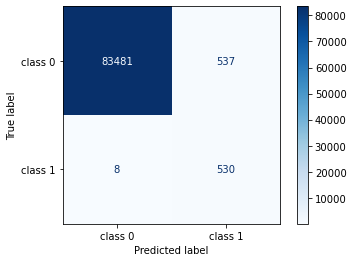

In [36]:
#performance results
print(classification_report(y_test, y_pred1, target_names=target_names))
plot_confusion_matrix(model1, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

  ## Over-sampling with SMOTE

In [38]:
# load library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit on the trainning dataset
X_smote , y_smote = smote.fit_resample(df_X_train_stand, y_train)

print('Origianl dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_smote))

Origianl dataset shape: Counter({0: 336056, 1: 2166})
Resample dataset shape: Counter({0: 336056, 1: 336056})


 ### b) Logistic Regression with Synthetic minority over-sampling technique (LR+SMOTE)

In [39]:
#Run grid search only on training set using cross-validation
parameters={'C':np.logspace(-3,3,7), 'penalty':["l1","l2"]}# l1 lasso l2 ridge
model2=GridSearchCV(LogisticRegression(solver='saga' ,max_iter=1000),parameters,cv=5, verbose=3)
model2.fit(X_smote,y_smote)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ...............C=0.001, penalty=l1;, score=0.994 total time= 7.5min
[CV 2/5] END ...............C=0.001, penalty=l1;, score=0.994 total time= 7.7min
[CV 3/5] END ...............C=0.001, penalty=l1;, score=0.994 total time= 7.9min
[CV 4/5] END ...............C=0.001, penalty=l1;, score=0.994 total time= 8.0min
[CV 5/5] END ...............C=0.001, penalty=l1;, score=0.994 total time= 8.3min
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.995 total time= 2.8min
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.995 total time= 2.8min
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.995 total time= 2.6min
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.995 total time= 2.9min
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.995 total time= 3.0min
[CV 1/5] END ................C=0.01, penalty=l1;, score=0.996 total time= 8.7min
[CV 2/5] END ................C=0.01, penalty=l1;

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, solver='saga'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=3)

In [40]:
print("tuned hpyerparameters :(best parameters) ",model2.best_params_)
print("accuracy :",model2.best_score_)
print('Best Model:',model2.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l1'}
accuracy : 0.9957685624200364
Best Model: LogisticRegression(max_iter=1000, penalty='l1', solver='saga')


In [41]:
y_pred2=model2.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      0.99      1.00     84018
     class 1       0.52      0.99      0.68       538

    accuracy                           0.99     84556
   macro avg       0.76      0.99      0.84     84556
weighted avg       1.00      0.99      0.99     84556



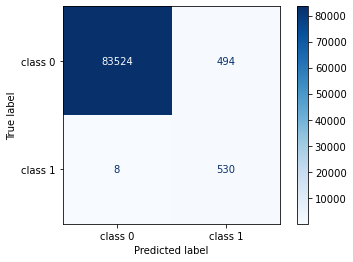

In [42]:
#performance results
print(classification_report(y_test, y_pred2, target_names=target_names))
plot_confusion_matrix(model2, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues); 

### c) Weighted Decision Tree (W-DT)

In [43]:
#Run grid search only on training set using cross-validation
parameters = {'criterion':['gini','entropy'], 'max_depth' : [2,4,6,8,10,12]}
model3 = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), parameters, cv=5, verbose=3)
# fit on the trainning dataset
model3.fit(df_X_train_stand, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .......criterion=gini, max_depth=2;, score=0.994 total time=   1.0s
[CV 2/5] END .......criterion=gini, max_depth=2;, score=0.993 total time=   0.5s
[CV 3/5] END .......criterion=gini, max_depth=2;, score=0.994 total time=   0.9s
[CV 4/5] END .......criterion=gini, max_depth=2;, score=0.995 total time=   0.9s
[CV 5/5] END .......criterion=gini, max_depth=2;, score=0.993 total time=   0.9s
[CV 1/5] END .......criterion=gini, max_depth=4;, score=0.998 total time=   1.0s
[CV 2/5] END .......criterion=gini, max_depth=4;, score=0.996 total time=   0.5s
[CV 3/5] END .......criterion=gini, max_depth=4;, score=0.998 total time=   1.0s
[CV 4/5] END .......criterion=gini, max_depth=4;, score=0.997 total time=   1.0s
[CV 5/5] END .......criterion=gini, max_depth=4;, score=0.998 total time=   1.0s
[CV 1/5] END .......criterion=gini, max_depth=6;, score=1.000 total time=   1.0s
[CV 2/5] END .......criterion=gini, max_depth=6;

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             verbose=3)

In [44]:
print("tuned hpyerparameters :(best parameters) ",model3.best_params_)
print("accuracy :",model3.best_score_)
print('Best Model:',model3.best_estimator_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 12}
accuracy : 0.9999319973184541
Best Model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=12)


In [45]:
y_pred3 = model3.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     84018
     class 1       0.96      0.29      0.44       538

    accuracy                           1.00     84556
   macro avg       0.98      0.64      0.72     84556
weighted avg       1.00      1.00      0.99     84556



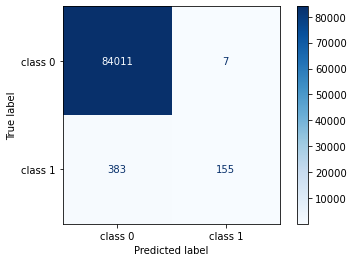

In [46]:
#performance results
print(classification_report(y_test, y_pred3, target_names=target_names))
plot_confusion_matrix(model3, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

## Undersampling using OSS
OneSidedSelection (OSS) is an undersampling technique that combines Tomek Links and the Condensed Nearest Neighbor (CNN) Rule. 

In [48]:
# Import library
from imblearn.under_sampling import OneSidedSelection

In [49]:
# define the undersampling method
oss = OneSidedSelection(random_state=0)
# fit on the trainning dataset
X_oss, y_oss = oss.fit_resample(df_X_train_stand, y_train)
# summarize the new class distribution
counter = Counter(y_oss)
print(counter)

Counter({0: 90470, 1: 2166})


### d) Weighted Support Vector Machine with One Sided Selection (SVM+OSS)

In [50]:
#Run grid search only on training set using cross-validation
parameters = {'C':[1, 5, 10] }
model4 = GridSearchCV(SVC(class_weight='balanced', kernel='rbf'), parameters, cv=5, verbose=3)
model4.fit(X_oss, y_oss)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...............................C=1;, score=0.998 total time=  27.2s
[CV 2/5] END ...............................C=1;, score=0.998 total time=  19.6s
[CV 3/5] END ...............................C=1;, score=0.998 total time=12.3min
[CV 4/5] END ...............................C=1;, score=0.999 total time=  23.2s
[CV 5/5] END ...............................C=1;, score=0.998 total time=  18.6s
[CV 1/5] END ...............................C=5;, score=0.999 total time=  12.9s
[CV 2/5] END ...............................C=5;, score=0.999 total time=  10.9s
[CV 3/5] END ...............................C=5;, score=0.999 total time=  12.9s
[CV 4/5] END ...............................C=5;, score=1.000 total time=  12.7s
[CV 5/5] END ...............................C=5;, score=0.999 total time=  11.3s
[CV 1/5] END ..............................C=10;, score=0.999 total time=  10.3s
[CV 2/5] END ..............................C=10;,

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1, 5, 10]}, verbose=3)

In [51]:
print("tuned hpyerparameters :(best parameters) ",model4.best_params_)
print("accuracy :",model4.best_score_)
print('Best Model:',model4.best_estimator_)

tuned hpyerparameters :(best parameters)  {'C': 10}
accuracy : 0.9991472016567707
Best Model: SVC(C=10, class_weight='balanced')


In [52]:
y_pred4 = model4.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     84018
     class 1       0.97      1.00      0.98       538

    accuracy                           1.00     84556
   macro avg       0.98      1.00      0.99     84556
weighted avg       1.00      1.00      1.00     84556



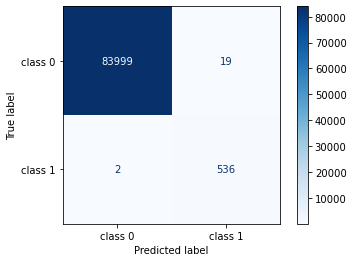

In [53]:
#performance results
print(classification_report(y_test, y_pred4, target_names=target_names))
plot_confusion_matrix(model4, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

### e)  XG Boost, Extreme Gradient Boosting (XGB)

In [56]:
#Run grid search only on training set using cross-validation
parameters = {'max_depth': [5, 10],'n_estimators': [100, 150], 'learning_rate': [0.1, 0.2]}
model5 = GridSearchCV(XGBClassifier(eval_metric='logloss',use_label_encoder =False), parameters, cv=5, verbose=3)
model5.fit(df_X_train_stand, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.9s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.6s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.8s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.7s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=1.000 total time=   4.8s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   6.3s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   6.2s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   6.3s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total time=   6.2s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=150;, score=1.000 total tim

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=

In [57]:
print("tuned hpyerparameters :(best parameters) ",model5.best_params_)
print("accuracy :",model5.best_score_)
print('Best Model:',model5.best_estimator_)

tuned hpyerparameters :(best parameters)  {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 150}
accuracy : 0.9999793035868139
Best Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=32,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


In [58]:
y_pred5 = model5.predict(df_X_test_stand)

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00     84018
     class 1       0.99      0.29      0.44       538

    accuracy                           1.00     84556
   macro avg       0.99      0.64      0.72     84556
weighted avg       1.00      1.00      0.99     84556



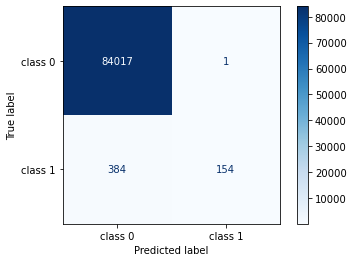

In [59]:
#performance results
print(classification_report(y_test, y_pred5, target_names=target_names))
plot_confusion_matrix(model5, df_X_test_stand, y_test, display_labels=target_names,cmap=plt.cm.Blues);

In [60]:
#save notebook session
import dill
dill.dump_session('session_esc-03.db')
#to restore a notebook session
#dill.load_session('session_esc-03.db')